# **Feature Engineering**

### **The goal here is to prepare your features for modeling so your model can learn efficiently.**

In [89]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import category_encoders as ce

In [90]:
df = pd.read_csv('../data/cleaned_manufacturing_data.csv')
df.head()

,recordDate,fiscalQuarter,productionDept,dayOfWeek,team,plannedEfficiency,standardMinuteValue,workInProgress,overtimeMinutes,performanceBonus,idleMinutes,idleWorkers,styleChangeCount,workerCount,efficiencyScore,idleOccurred
0,2015-02-24,Q4,Stitching Unit,Tuesday,Line-S1,0.6,22.53,800.5,5040,0,0.0,0,Minor Style Revision,42.0,0.268214,0
1,2015-01-19,Q3,Stitching Unit,Monday,Line-F3,0.8,11.41,1028.0,4380,50,0.0,0,No Style Change,31.0,0.800359,0
2,2015-01-06,Q1,Finishing & Quality,Tuesday,Line-C2,0.8,2.90,1039.0,1440,0,0.0,0,No Style Change,8.0,0.681061,0
3,2015-02-24,Q4,Finishing & Quality,Tuesday,Line-S2,0.7,3.90,1039.0,960,0,0.0,0,No Style Change,8.0,0.325000,0
4,2015-01-04,Q1,Finishing & Quality,Sunday,Line-C1,0.8,2.90,1039.0,960,0,0.0,0,No Style Change,8.0,0.667604,0


## **Handle Categorical Features**

### **One-Hot Encode nominal categorical columns**

In [91]:
n_cols = ['productionDept', 'dayOfWeek']
encoder = ce.OneHotEncoder(cols=n_cols, use_cat_names=True, drop_invariant=True)
df = encoder.fit_transform(df)

In [92]:
df['recordDate'] = pd.to_datetime(df['recordDate'])
df['month'] = df['recordDate'].dt.month
df['dayOfMonth'] = df['recordDate'].dt.day
df['weekOfYear'] = df['recordDate'].dt.isocalendar().week.astype(int)
df['dayOfYear'] = df['recordDate'].dt.dayofyear

In [93]:
df.head(5)

,recordDate,fiscalQuarter,productionDept_Stitching Unit,productionDept_ Finishing & Quality,productionDept_Finishing & Quality,dayOfWeek_Tuesday,dayOfWeek_Monday,dayOfWeek_Sunday,dayOfWeek_Thursday,dayOfWeek_Saturday,...,idleMinutes,idleWorkers,styleChangeCount,workerCount,efficiencyScore,idleOccurred,month,dayOfMonth,weekOfYear,dayOfYear
0,2015-02-24,Q4,1,0,0,1,0,0,0,0,...,0.0,0,Minor Style Revision,42.0,0.268214,0,2,24,9,55
1,2015-01-19,Q3,1,0,0,0,1,0,0,0,...,0.0,0,No Style Change,31.0,0.800359,0,1,19,4,19
2,2015-01-06,Q1,0,1,0,1,0,0,0,0,...,0.0,0,No Style Change,8.0,0.681061,0,1,6,2,6
3,2015-02-24,Q4,0,0,1,1,0,0,0,0,...,0.0,0,No Style Change,8.0,0.325000,0,2,24,9,55
4,2015-01-04,Q1,0,1,0,0,0,1,0,0,...,0.0,0,No Style Change,8.0,0.667604,0,1,4,1,4


### **Label Encode styleChangeCount**

In [94]:
style_mapping = {'No Style Change': 0, 'Minor Style Revision': 1, 'Major Style Revision': 2}
df['styleChangeCount'] = df['styleChangeCount'].map(style_mapping)

In [95]:
df['styleChangeCount'].head(5)

0    1.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: styleChangeCount, dtype: float64

In [96]:
quarter_mapping = {'Q1': 1, 'Q2': 2, 'Q3': 3, 'Q4': 4}
df['fiscalQuarter'] = df['fiscalQuarter'].map(quarter_mapping)

### **Identify columns that might have NaNs introduced by mapping or original data**

In [97]:
cols_with_potential_nan = ['styleChangeCount', 'fiscalQuarter', 'workerCount', 'workInProgress', 'overtimeMinutes']
for col in cols_with_potential_nan:
    if col in df.columns and df[col].isnull().any():
        if df[col].dtype == 'object': 
            df[col].fillna(df[col].mode()[0], inplace=True)
        else:
            df[col].fillna(df[col].median(), inplace=True)

print("\nNaNs after imputation:")
print(df.isnull().sum()[df.isnull().sum() > 0])


NaNs after imputation:
Series([], dtype: int64)


C:\Users\harsh\AppData\Local\Temp\ipykernel_19408\3161980155.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
C:\Users\harsh\AppData\Local\Temp\ipykernel_19408\3161980155.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For examp

### **Binary feature for idleMinutes**

In [98]:
df['idleOccurred'] = np.where(df['idleMinutes'] > 0, 1, 0)
df.drop(columns=['idleMinutes'], inplace=True)

In [99]:
df['idleOccurred'].head(5)

0    0
1    0
2    0
3    0
4    0
Name: idleOccurred, dtype: int64

### **Derived Features**

In [110]:
df['workerCount'] = df['workerCount'].replace(0, 1)
df['workPerWorker'] = df['workInProgress'] / df['workerCount']
df['overtimePerWorker'] = df['overtimeMinutes'] / df['workerCount']

In [111]:
df['workPerWorker'].head(5),df['workerCount'].head(5),df['overtimePerWorker'].head(5)

(0   -5.001813
 1    0.172635
 2   -0.042571
 3   -0.042571
 4   -0.042571
 Name: workPerWorker, dtype: float64,
 0    0.332556
 1   -0.162609
 2   -1.197953
 3   -1.197953
 4   -1.197953
 Name: workerCount, dtype: float64,
 0    0.477675
 1    0.270757
 2    0.791158
 3    0.914327
 4    0.914327
 Name: overtimePerWorker, dtype: float64)

In [112]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [113]:
for col in ['workPerWorker', 'overtimePerWorker']:
    if col in df.columns and df[col].isnull().any():
        df[col].fillna(df[col].median(), inplace=True)

### **Feature Scaling (for linear models)**

In [115]:
num_features = ['plannedEfficiency', 'standardMinuteValue', 'workInProgress','overtimeMinutes', 'workerCount', 'workPerWorker', 'overtimePerWorker','fiscalQuarter']

scaler = StandardScaler()
df[num_features] = scaler.fit_transform(df[num_features])

### **Split Dataset into Train/Test**

In [116]:
X = df.drop(columns=['efficiencyScore', 'recordDate', 'team'])
y = df['efficiencyScore']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [117]:
print("\nFinal NaN check in X_train:")
print(X_train.isnull().sum()[X_train.isnull().sum() > 0])
print("\nFinal NaN check in X_test:")
print(X_test.isnull().sum()[X_test.isnull().sum() > 0])


Final NaN check in X_train:
Series([], dtype: int64)

Final NaN check in X_test:
Series([], dtype: int64)


In [118]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train mean:", y_train.mean())
print("y_test mean:", y_test.mean())

X_train shape: (954, 25)
X_test shape: (239, 25)
y_train mean: 0.7334185707138365
y_test mean: 0.7438215215355648


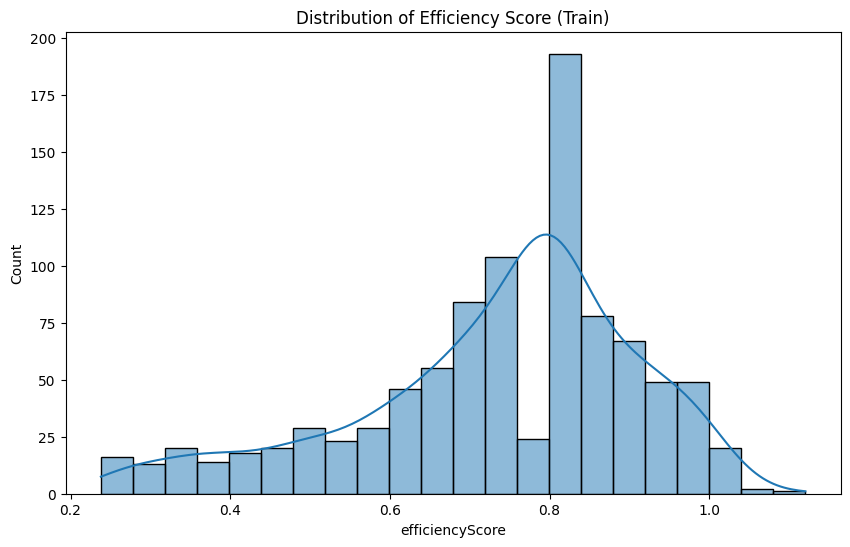

In [119]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.histplot(y_train, kde=True)
plt.title('Distribution of Efficiency Score (Train)')
plt.show()

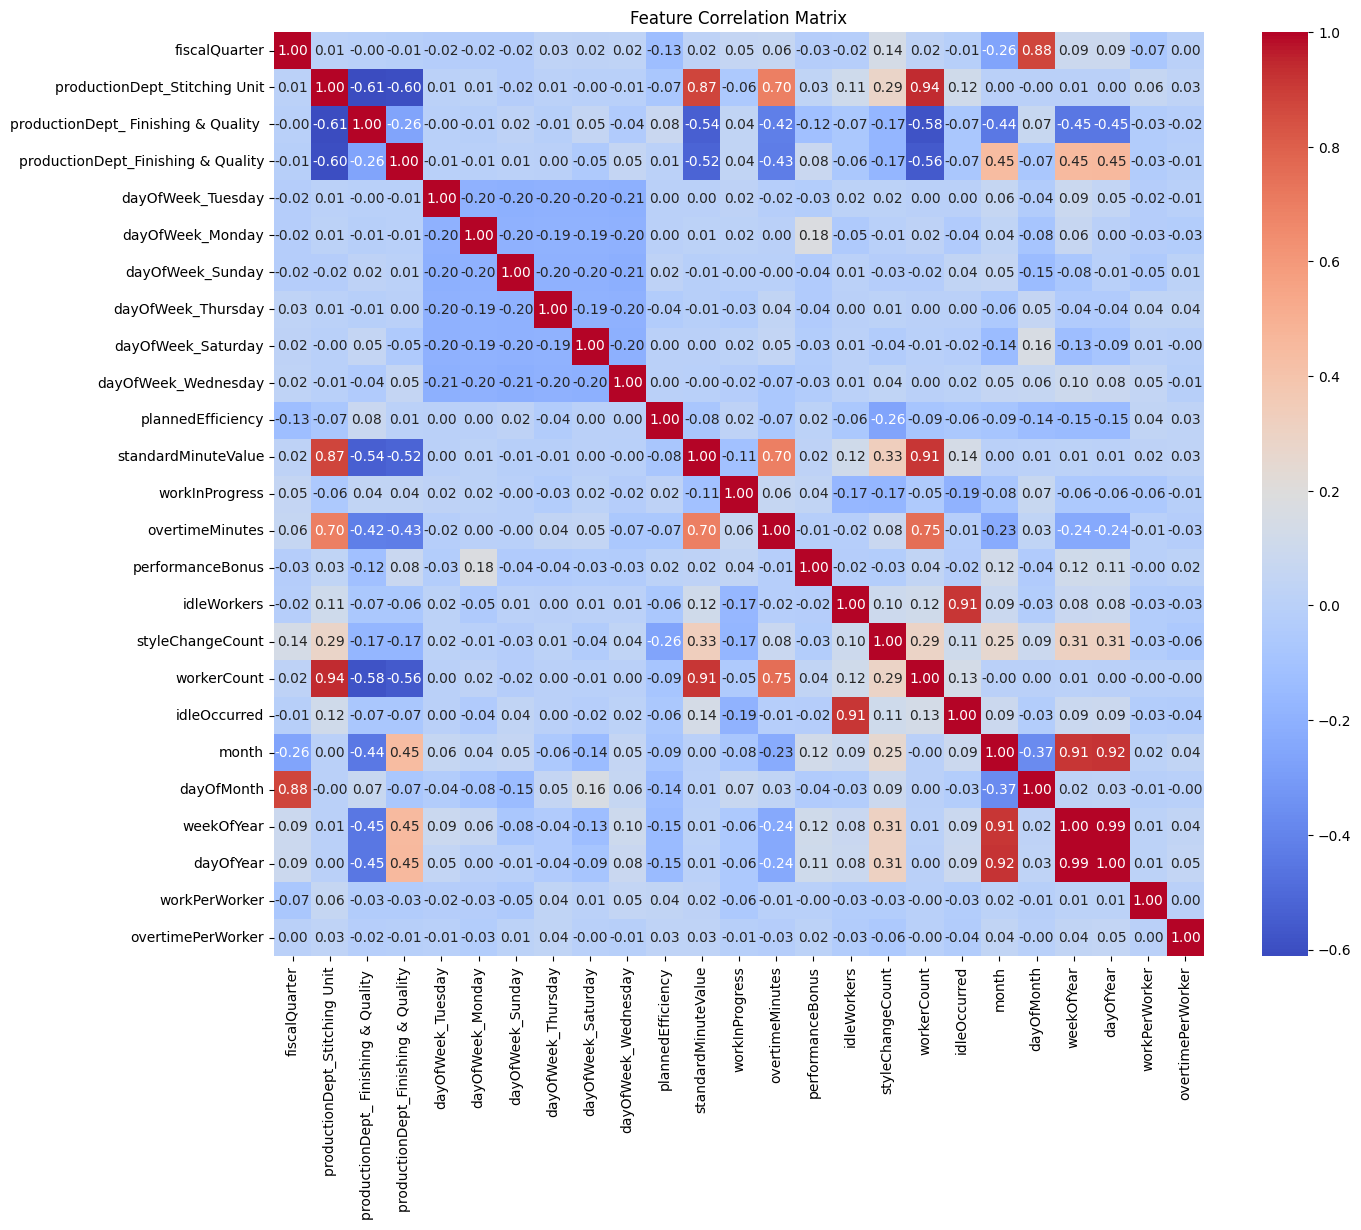

In [120]:
plt.figure(figsize=(15, 12))
sns.heatmap(X_train.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.show()

### **Numeric columns after scaling**

In [121]:
X_train[num_features].head()

,plannedEfficiency,standardMinuteValue,workInProgress,overtimeMinutes,workerCount,workPerWorker,overtimePerWorker,fiscalQuarter
63,0.835677,-0.999001,0.050998,-0.560452,-0.882849,-0.071546,-0.025022,-1.164699
141,0.835677,-0.957893,0.050998,0.453954,-0.432699,-0.077930,-0.472873,-1.164699
538,-1.817583,0.338379,-1.663384,-0.173134,-0.072579,2.369172,0.440568,-0.259496
371,0.835677,-1.018185,0.050998,-1.095321,-1.197953,-0.069932,0.049314,-0.259496
358,0.172362,1.071928,1.585676,0.749054,1.052796,0.094587,-0.004632,-0.259496


### **Train-Test DATASET**

In [122]:
X_train.to_csv('../data/Train-Test/X_train.csv', index=False)
X_test.to_csv('../data/Train-Test/X_test.csv', index=False)
y_train.to_csv('../data/Train-Test/y_train.csv', index=False)
y_test.to_csv('../data/Train-Test/y_test.csv', index=False)